In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def Bernoulli(probability):
    u = np.random.uniform(0, 1)
    if u <= probability:
        return True
    else:
        return False

def generate_ER_graph(num_of_vertices , initial_density_of_1 , probability):
    G = nx.MultiGraph()
    num_of_1 = 0
    num_of_0 = num_of_vertices
    G.add_nodes_from(range(num_of_vertices), opinion = 0)
    for i in range(num_of_vertices):
        if Bernoulli(initial_density_of_1):
            G.nodes[i]["opinion"] = 1
            num_of_1 += 1
            num_of_0 -= 1
    lp = np.log(1.0 - probability)
    v = 1
    w = -1
    while v < num_of_vertices:
        lr = np.log(1.0 - np.random.uniform(0, 1))
        w = w + 1 + int(lr / lp)
        while w >= v and v < num_of_vertices:
            w = w - v
            v = v + 1
        if v < num_of_vertices:
            G.add_edge(v, w , disagreeing = 0)
            if G.nodes[v]["opinion"] != G.nodes[w]["opinion"]:
                G.edges[v , w , 0]["disagreeing"] = 1
    disagreeing_edges = [edge for edge in G.edges(keys = True) if G.edges[edge]["disagreeing"] == 1]
    
    return G , num_of_0 , num_of_1 , disagreeing_edges

def choose_edge(disagreeing_edges):
    if not disagreeing_edges:
        return False
    index = np.random.choice(len(disagreeing_edges))
    chosen_edge = disagreeing_edges[index]
    
    return chosen_edge

def relabeling_step(G , chosen_edge , num_of_1 , num_of_0 , disagreeing_edges):
    if Bernoulli(1/2):
        root = chosen_edge[0]
        target = chosen_edge[1]
    else:
        root = chosen_edge[1]
        target = chosen_edge[0]
    G.nodes[target]["opinion"] = G.nodes[root]["opinion"]
    if G.nodes[root]["opinion"] == 0:
        num_of_0 += 1
        num_of_1 -= 1
    else:
        num_of_0 -= 1
        num_of_1 += 1
    for node in G.neighbors(target):
        number = G.number_of_edges(min(node , target) , max(node , target))
        if G.nodes[node]["opinion"] != G.nodes[target]["opinion"]:
            for index in range(number):
                disagreeing_edges.append((min(node , target) , max(node , target) , index))
        else:
            for index in range(number):
                disagreeing_edges.remove((min(node , target) , max(node , target) , index))
                
    return G , num_of_0 , num_of_1 , disagreeing_edges

def rewiring_step(G , chosen_edge , disagreeing_edges , mode):
    if Bernoulli(1/2):
        root = chosen_edge[0]
    else:
        root = chosen_edge[1]
    if mode == "rewire_to_random":
        target = np.random.choice([i for i in G.nodes() if i != root])
    elif mode == "rewire_to_same":
        candidate = [i for i in G.nodes() if i != root and G.nodes[i]["opinion"] == G.nodes[root]["opinion"]]
        if not candidate:
            return None , None
        target = np.random.choice(candidate)
    key = G.new_edge_key(chosen_edge[0] , chosen_edge[1])
    G.remove_edge(chosen_edge[0] , chosen_edge[1] , key - 1)
    disagreeing_edges.remove((chosen_edge[0] , chosen_edge[1] , key - 1))
    if G.nodes[root]["opinion"] != G.nodes[target]["opinion"]:
        key = G.new_edge_key(min(root , target) , max(root , target))
        G.add_edge(min(root , target) , max(root , target) , disagreeing = 1)
        disagreeing_edges.append((min(root , target) , max(root , target) , key))
    else:
        key = G.new_edge_key(min(root , target) , min(root , target))
        G.add_edge(min(root , target) , max(root , target) , disagreeing = 0)

    return G , disagreeing_edges

def evolving_voter_model(num_of_vertices , alpha , num_of_steps , mode , seed = 2024 , initial_density_of_1 = 0.5 , probability = 0.5):
    np.random.seed(seed)
    G , num_of_0 , num_of_1 , disagreeing_edges = generate_ER_graph(num_of_vertices , initial_density_of_1 , probability)
    result = 0
    for s in range(num_of_steps):
        chosen_edge = choose_edge(disagreeing_edges)
        if chosen_edge == False:
            return result
        if Bernoulli(1 - alpha):
            G , num_of_0 , num_of_1 , disagreeing_edges = relabeling_step(G , chosen_edge , num_of_1 , num_of_0 , disagreeing_edges)
        else:
            G , disagreeing_edges = rewiring_step(G , chosen_edge , disagreeing_edges , mode)
            if not G and not disagreeing_edges:
                return result
        if num_of_1 == 0 or num_of_0 == 0:
            return 0
        result = min(num_of_1 , num_of_0) / num_of_vertices
        
    return result

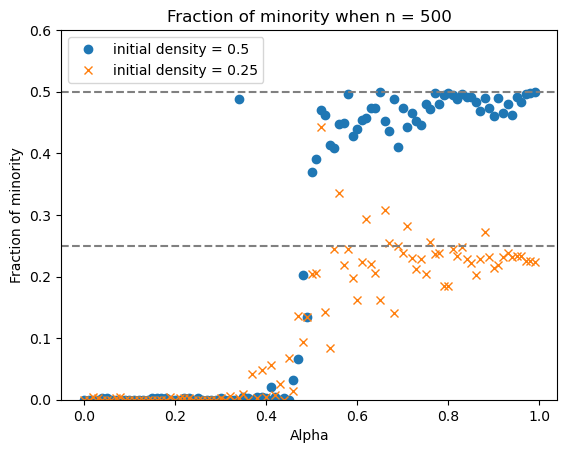

In [3]:
results_1 = []
results_2 = []
num_of_vertices = 1000
num_of_steps = num_of_vertices**2
mode = "rewire_to_same"
alpha_range = np.arange(0 , 1 , 0.01)
for alpha in alpha_range:
    results_1.append(evolving_voter_model(num_of_vertices , alpha , num_of_steps , mode , probability = 5 / num_of_vertices))
    results_2.append(evolving_voter_model(num_of_vertices , alpha , num_of_steps , mode , initial_density_of_1 = 0.25 , probability = 5 / num_of_vertices))
plt.plot(alpha_range , results_1 , label = "initial density = 0.5" , linestyle = "none" , marker = "o")
plt.plot(alpha_range , results_2 , label = "initial density = 0.25" , linestyle = "none" , marker = "x")
title = "Fraction of minority when n = " + str(num_of_vertices)
plt.title(title)
plt.ylim(0 , 0.6)
plt.xlabel("Alpha")
plt.ylabel("Fraction of minority")
plt.legend(loc = "upper left")
plt.axhline(y = 0.5 , color = 'gray' , linestyle = '--')
plt.axhline(y = 0.25 , color = 'gray' , linestyle = '--')
plt.show()